## Setup


In [458]:
import json
import geopandas as gpd
from tqdm import tqdm
import matplotlib.pyplot as plt
import geopandas as gpd
from shapely.geometry import Polygon

In [459]:
with open("../intermediate_data/fire_features_with_distances.json", "r") as file:
    feature_list = json.load(file)

In [460]:
for feature in feature_list:
    feature["attributes"]["shortest_distance_to_pueblo"] = feature["attributes"]["shortest_distance_to_pueblo"][0]

In [461]:
def convert_to_geodataframe(feature_list):
    processed_features = []

    for i, feature in tqdm(enumerate(feature_list)):
        attributes = feature['attributes']
        geometry = feature.get('geometry')

        # some geometries are not rings; this can be problematic, so
        # I add a check and log exceptions
        if geometry and 'rings' in geometry:
            try:
                polygon = Polygon(geometry['rings'][0])
                processed_features.append({**attributes, 'geometry': polygon})

            except Exception as e:
                print(f"Problem with geometry for OBJECTID {
                      attributes.get('OBJECTID')}: {e}")

        elif geometry and 'curveRings' in geometry:
            try:
                polygon = Polygon(geometry['curveRings'][0])
                processed_features.append({**attributes, 'geometry': polygon})

            except Exception as e:
                print(f"Problem with geometry for OBJECTID {
                      attributes.get('OBJECTID')}: {e}")
        else:
            print(f"Skipping feature with OBJECTID {attributes.get(
                'OBJECTID')}: No 'rings' found. Instead, got: {geometry}\n")

    gdf = gpd.GeoDataFrame(processed_features, geometry='geometry')
    return gdf

In [462]:
gdf = convert_to_geodataframe(feature_list)

0it [00:00, ?it/s]

110745it [00:39, 8642.65it/s] 

Problem with geometry for OBJECTID 109605: could not convert string to float: 'b'
Problem with geometry for OBJECTID 110224: could not convert string to float: 'a'
Problem with geometry for OBJECTID 110639: could not convert string to float: 'b'
Problem with geometry for OBJECTID 111431: could not convert string to float: 'a'


114594it [00:39, 11264.21it/s]

Problem with geometry for OBJECTID 111897: could not convert string to float: 'b'
Problem with geometry for OBJECTID 112410: could not convert string to float: 'a'
Problem with geometry for OBJECTID 112415: could not convert string to float: 'a'
Problem with geometry for OBJECTID 113411: could not convert string to float: 'a'
Problem with geometry for OBJECTID 113665: could not convert string to float: 'a'
Problem with geometry for OBJECTID 113738: could not convert string to float: 'a'
Problem with geometry for OBJECTID 113766: could not convert string to float: 'a'
Problem with geometry for OBJECTID 113805: could not convert string to float: 'a'
Problem with geometry for OBJECTID 114309: could not convert string to float: 'a'
Problem with geometry for OBJECTID 114322: could not convert string to float: 'a'


117326it [00:40, 12493.62it/s]

Problem with geometry for OBJECTID 115629: could not convert string to float: 'a'
Problem with geometry for OBJECTID 115974: could not convert string to float: 'a'
Problem with geometry for OBJECTID 116235: could not convert string to float: 'c'
Problem with geometry for OBJECTID 117086: could not convert string to float: 'a'


121783it [00:40, 13752.55it/s]

Problem with geometry for OBJECTID 119582: could not convert string to float: 'a'
Problem with geometry for OBJECTID 119617: could not convert string to float: 'a'
Problem with geometry for OBJECTID 119751: could not convert string to float: 'a'
Problem with geometry for OBJECTID 119982: could not convert string to float: 'a'
Problem with geometry for OBJECTID 120212: could not convert string to float: 'a'
Problem with geometry for OBJECTID 120678: could not convert string to float: 'a'
Problem with geometry for OBJECTID 121010: could not convert string to float: 'a'
Problem with geometry for OBJECTID 122264: could not convert string to float: 'a'


127197it [00:40, 12699.45it/s]

Problem with geometry for OBJECTID 125745: could not convert string to float: 'a'
Problem with geometry for OBJECTID 127492: could not convert string to float: 'a'


135061it [00:41, 3276.40it/s] 


## Data Exploration & Simplification

The section below documents my data exploration to figure out which columns to keep and drop. Please feel free to skip.


In [463]:
# print the columns of the dataframe to figure out
gdf.columns

Index(['OBJECTID', 'USGS_Assigned_ID', 'Assigned_Fire_Type', 'Fire_Year',
       'Fire_Polygon_Tier', 'Fire_Attribute_Tiers', 'GIS_Acres',
       'GIS_Hectares', 'Source_Datasets', 'Listed_Fire_Types',
       'Listed_Fire_Names', 'Listed_Fire_Codes', 'Listed_Fire_IDs',
       'Listed_Fire_IRWIN_IDs', 'Listed_Fire_Dates', 'Listed_Fire_Causes',
       'Listed_Fire_Cause_Class', 'Listed_Rx_Reported_Acres',
       'Listed_Map_Digitize_Methods', 'Listed_Notes', 'Processing_Notes',
       'Wildfire_Notice', 'Prescribed_Burn_Notice', 'Wildfire_and_Rx_Flag',
       'Overlap_Within_1_or_2_Flag', 'Circleness_Scale', 'Circle_Flag',
       'Exclude_From_Summary_Rasters', 'Shape_Length', 'Shape_Area',
       'shortest_distance_to_pueblo', 'centroid_distance_to_pueblo',
       'geometry'],
      dtype='object')

In [464]:
columns_to_include = [
    "USGS_Assigned_ID",
    "Assigned_Fire_Type",
    "Fire_Year",
    "GIS_Acres",
    "Shape_Length",
    "Shape_Area",
    "shortest_distance_to_pueblo",
    "centroid_distance_to_pueblo",
    "geometry"
]

simplified_gdf = (gdf.
                  filter(columns_to_include))

In [465]:
DISTANCE_CUTOFF = 1800

fires_within_1800_mi = (
    simplified_gdf
    .pipe(lambda x: x[x['centroid_distance_to_pueblo'] <= DISTANCE_CUTOFF])
)

fires_within_1800_mi

,USGS_Assigned_ID,Assigned_Fire_Type,Fire_Year,GIS_Acres,Shape_Length,Shape_Area,shortest_distance_to_pueblo,centroid_distance_to_pueblo,geometry
0,1,Wildfire,1860,3940.207089,64888.449849,1.594545e+07,1137.124505,1139.206473,"POLYGON ((-1883775.596 1194154.192, -1883782.4..."
1,2,Wildfire,1860,772.518249,23462.288613,3.126270e+06,1135.778280,1136.854043,"POLYGON ((-1887470.131 1187759.244, -1887546.2..."
2,3,Wildfire,1860,333.020409,6679.573569,1.347686e+06,1138.124278,1138.643550,"POLYGON ((-1889386.119 1190683.928, -1889454.1..."
3,4,Wildfire,1870,22294.993577,84700.719226,9.022464e+07,778.046670,781.198321,"POLYGON ((-1428896.297 864980.034, -1428690.21..."
4,5,Wildfire,1870,36.985574,2937.265383,1.496753e+05,637.107402,637.246282,"POLYGON ((-1371410.414 595942.396, -1371424.53..."
...,...,...,...,...,...,...,...,...,...
135028,135057,Prescribed Fire,2020,16.412148,2168.900740,6.641761e+04,1024.698218,1024.831573,"POLYGON ((-2008802.496 729335.562, -2008682.90..."
135029,135058,Prescribed Fire,2020,7.050837,978.666221,2.853373e+04,804.543266,804.651400,"POLYGON ((-1648510.319 666410.727, -1648817.72..."
135030,135059,Prescribed Fire,2020,9.342668,1958.326660,3.780843e+04,804.367278,804.416914,"POLYGON ((-1649244.566 664993.758, -1649215.60..."
135031,135060,Prescribed Fire,2020,0.996962,225.866452,4.034562e+03,276.836936,276.859208,"POLYGON ((-1017808.425 140344.112, -1017805.50..."


In [466]:
wildfires_within_1800_mi = (
    fires_within_1800_mi
    .pipe(lambda x: x[x["Assigned_Fire_Type"] == "Wildfire"])
)

wildfires_within_1800_mi

,USGS_Assigned_ID,Assigned_Fire_Type,Fire_Year,GIS_Acres,Shape_Length,Shape_Area,shortest_distance_to_pueblo,centroid_distance_to_pueblo,geometry
0,1,Wildfire,1860,3940.207089,64888.449849,1.594545e+07,1137.124505,1139.206473,"POLYGON ((-1883775.596 1194154.192, -1883782.4..."
1,2,Wildfire,1860,772.518249,23462.288613,3.126270e+06,1135.778280,1136.854043,"POLYGON ((-1887470.131 1187759.244, -1887546.2..."
2,3,Wildfire,1860,333.020409,6679.573569,1.347686e+06,1138.124278,1138.643550,"POLYGON ((-1889386.119 1190683.928, -1889454.1..."
3,4,Wildfire,1870,22294.993577,84700.719226,9.022464e+07,778.046670,781.198321,"POLYGON ((-1428896.297 864980.034, -1428690.21..."
4,5,Wildfire,1870,36.985574,2937.265383,1.496753e+05,637.107402,637.246282,"POLYGON ((-1371410.414 595942.396, -1371424.53..."
...,...,...,...,...,...,...,...,...,...
125213,125240,Wildfire,2019,2707.972005,15247.605295,1.095877e+07,223.622700,225.558881,"POLYGON ((-1053400.695 -192307.078, -1053438.1..."
125366,125393,Wildfire,2019,2661.472459,51691.985678,1.077060e+07,1445.429250,1445.618420,"POLYGON ((1452467.255 -669594.579, 1452444.328..."
127198,127226,Wildfire,2020,471.592503,9578.493276,1.908467e+06,1011.320532,1012.089256,"POLYGON ((631347.374 -1020210.11, 632158.333 -..."
130435,130464,Wildfire,1987,16.673322,1201.447427,6.747454e+04,1045.019029,1045.118924,"POLYGON ((-2104386.345 613774.003, -2104493.80..."


In [467]:
CLOSER_FIRE_CUTOFF = 650

wildfires_within_650_mi = (
    wildfires_within_1800_mi
    .pipe(lambda x: x[x["centroid_distance_to_pueblo"] <= CLOSER_FIRE_CUTOFF])
)

wildfires_within_650_mi

,USGS_Assigned_ID,Assigned_Fire_Type,Fire_Year,GIS_Acres,Shape_Length,Shape_Area,shortest_distance_to_pueblo,centroid_distance_to_pueblo,geometry
4,5,Wildfire,1870,36.985574,2937.265383,1.496753e+05,637.107402,637.246282,"POLYGON ((-1371410.414 595942.396, -1371424.53..."
8,9,Wildfire,1880,14946.172721,64423.416282,6.048502e+07,39.263196,43.833024,"POLYGON ((-741983.427 -101388.883, -741883.607..."
9,10,Wildfire,1880,3115.787359,16474.164949,1.260914e+07,418.727182,420.305756,"POLYGON ((-606723.741 539312.302, -606687.256 ..."
10,11,Wildfire,1880,1327.574260,9211.284268,5.372502e+06,425.238654,425.854087,"POLYGON ((-604762.363 549099.569, -604764.967 ..."
11,12,Wildfire,1880,455.900592,6699.492336,1.844964e+06,426.151352,426.877275,"POLYGON ((-579457.828 546999.384, -579457.985 ..."
...,...,...,...,...,...,...,...,...,...
117172,117191,Wildfire,2013,210.199636,3849.471786,8.506477e+05,535.490597,535.883592,"POLYGON ((-477366.678 710676.762, -477367.406 ..."
121034,121060,Wildfire,2016,351.613292,9246.421333,1.422929e+06,246.099949,246.618682,"POLYGON ((-499632.927 -516323.383, -499625.23 ..."
124163,124190,Wildfire,2018,271.762714,6702.221404,1.099785e+06,207.584553,208.279177,"POLYGON ((-921261.409 -439295.713, -921262 -43..."
125173,125200,Wildfire,2019,9251.423415,41346.331760,3.743918e+07,377.377323,380.285212,"POLYGON ((-1067819.058 -695471.57, -1067809.60..."


In [468]:
YEAR_CUTOFF = 1961

close_wildfires_since1961 = (
    wildfires_within_650_mi
    .pipe(lambda x: x[x["Fire_Year"] >= YEAR_CUTOFF])
)

close_wildfires_since1961

,USGS_Assigned_ID,Assigned_Fire_Type,Fire_Year,GIS_Acres,Shape_Length,Shape_Area,shortest_distance_to_pueblo,centroid_distance_to_pueblo,geometry
13535,13536,Wildfire,1961,9691.440667,46801.824908,3.921987e+07,626.124172,628.293842,"POLYGON ((-1669193.583 -252228.935, -1669188.7..."
13545,13546,Wildfire,1961,5941.755818,24609.660290,2.404543e+07,582.357461,586.577089,"POLYGON ((-1394870.85 448209.973, -1394857.289..."
13548,13549,Wildfire,1961,9870.377328,28134.851067,3.994400e+07,195.308979,197.778156,"POLYGON ((-891047.798 -449060.664, -891257.758..."
13549,13550,Wildfire,1961,4995.989520,15980.638546,2.021805e+07,186.560345,188.140452,"POLYGON ((-892212.657 -419878.538, -892005.147..."
13550,13551,Wildfire,1961,4995.932412,15980.022693,2.021782e+07,199.445630,201.025506,"POLYGON ((-896243.452 -444414.862, -896035.863..."
...,...,...,...,...,...,...,...,...,...
117172,117191,Wildfire,2013,210.199636,3849.471786,8.506477e+05,535.490597,535.883592,"POLYGON ((-477366.678 710676.762, -477367.406 ..."
121034,121060,Wildfire,2016,351.613292,9246.421333,1.422929e+06,246.099949,246.618682,"POLYGON ((-499632.927 -516323.383, -499625.23 ..."
124163,124190,Wildfire,2018,271.762714,6702.221404,1.099785e+06,207.584553,208.279177,"POLYGON ((-921261.409 -439295.713, -921262 -43..."
125173,125200,Wildfire,2019,9251.423415,41346.331760,3.743918e+07,377.377323,380.285212,"POLYGON ((-1067819.058 -695471.57, -1067809.60..."


## Defining the Smoke Estimate


How much smoke affects a point in space (in my case, Pueblo, CO) should increase with the acreage burned and decrease with the distance from the source.

Already, this requires making a choice, since we have two notions of distance available in our data: do we use the centroid distance (Pueblo, CO to the centroid of the fire area) or the edge distance (Pueblo to the closest point in the fire area).

I hypothesized that it wouldn't make a big difference for most fires, since most fires aren't very large. To test this, I checked the data:


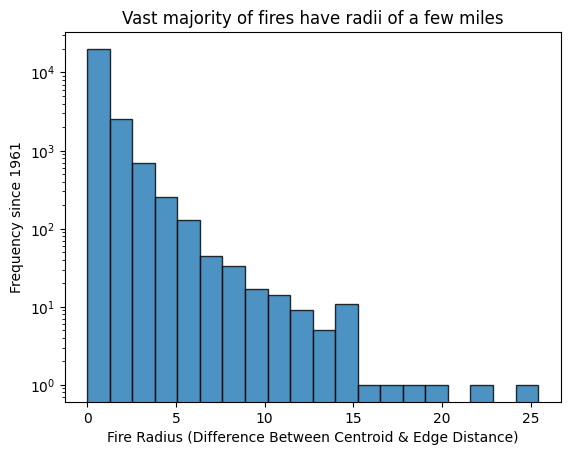

In [651]:
fire_radius = close_wildfires_since1961["centroid_distance_to_pueblo"] - \
    close_wildfires_since1961["shortest_distance_to_pueblo"]

plt.hist(fire_radius, bins=20, alpha=0.8, edgecolor="black")
plt.yscale("log")
plt.title("Vast majority of fires have radii of a few miles")
plt.xlabel("Fire Radius (Difference Between Centroid & Edge Distance)")
plt.ylabel("Frequency since 1961")
plt.show()

A few outlier fires have larger radii; most are small.

Therefore, to simplify modeling, I will use the **centroid distance**. This allows me to (simplistically) simulate the fire as coming from a point source, with all of the burning acreage coming from that point source. At the same time, using the centroid distance doesn't sacrifice much vs. using the edge distance, since in most cases these are basically equivalent.

Moreover, I will assume that the point source generates some volume of smoke, and that _on average_ (across all wildfires since 1961) this smoke dissipates roughly equally in all directions. This is not completely because there are systematic factors (terrain, wind patterns) that mean smoke does not spread equally in all directions, but it is a reasonable first approximation for my purposes.

The assumption that smoke dissipates equally in all directions from the point source allows me to use an inverse-square law. At a given point in time, a constant volume of smoke emanating from the point-source fills a half-sphere around the point source with radius $r$, where $r$ indicates the furthest point the smoke has reached. I will call this the "smoke radius"

Imagine some point $d$ (like a city), inside of the smoke radius ($d < r$). The volume of smoke inside of that point (between $d$ and the point source of the smoke) is proportional to $d^2$. Therefore, the smoke density at point $d$ is _inversely_ proportional to $d^2$.

Let $SIE$ indicate the Smoke Intensity Estimate. I want this to increase linearly with the acreage burned ($A$) and to be inversely proportional to the squared centroid distance $d$ between the city and the "point source" generating the smoke:

$$SIE \propto \frac{A}{d^2}$$


In the code below I implement this notion of smoke intensity. The units are irrelevant for my purposes, so I keep them as they are.

In [470]:
close_wildfires_since1961.loc[:, "smoke_intensity_est"] = (close_wildfires_since1961["GIS_Acres"] /
                                                           ((close_wildfires_since1961["centroid_distance_to_pueblo"])**2))

close_wildfires_since1961

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/geopandas/geodataframe.py:1819: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


,USGS_Assigned_ID,Assigned_Fire_Type,Fire_Year,GIS_Acres,Shape_Length,Shape_Area,shortest_distance_to_pueblo,centroid_distance_to_pueblo,geometry,smoke_intensity_est
13535,13536,Wildfire,1961,9691.440667,46801.824908,3.921987e+07,626.124172,628.293842,"POLYGON ((-1669193.583 -252228.935, -1669188.7...",0.024551
13545,13546,Wildfire,1961,5941.755818,24609.660290,2.404543e+07,582.357461,586.577089,"POLYGON ((-1394870.85 448209.973, -1394857.289...",0.017269
13548,13549,Wildfire,1961,9870.377328,28134.851067,3.994400e+07,195.308979,197.778156,"POLYGON ((-891047.798 -449060.664, -891257.758...",0.252335
13549,13550,Wildfire,1961,4995.989520,15980.638546,2.021805e+07,186.560345,188.140452,"POLYGON ((-892212.657 -419878.538, -892005.147...",0.141142
13550,13551,Wildfire,1961,4995.932412,15980.022693,2.021782e+07,199.445630,201.025506,"POLYGON ((-896243.452 -444414.862, -896035.863...",0.123627
...,...,...,...,...,...,...,...,...,...,...
117172,117191,Wildfire,2013,210.199636,3849.471786,8.506477e+05,535.490597,535.883592,"POLYGON ((-477366.678 710676.762, -477367.406 ...",0.000732
121034,121060,Wildfire,2016,351.613292,9246.421333,1.422929e+06,246.099949,246.618682,"POLYGON ((-499632.927 -516323.383, -499625.23 ...",0.005781
124163,124190,Wildfire,2018,271.762714,6702.221404,1.099785e+06,207.584553,208.279177,"POLYGON ((-921261.409 -439295.713, -921262 -43...",0.006265
125173,125200,Wildfire,2019,9251.423415,41346.331760,3.743918e+07,377.377323,380.285212,"POLYGON ((-1067819.058 -695471.57, -1067809.60...",0.063972


In [471]:
close_wildfires_since1961["smoke_intensity_est"].describe()

count    2.374700e+04
mean     3.931717e-02
std      8.710304e-01
min      4.040682e-11
25%      7.274812e-05
50%      5.155988e-04
75%      5.432039e-03
max      9.130211e+01
Name: smoke_intensity_est, dtype: float64

## Aggregating Annual Smoke Contributions from Many Fires

Ultimately, we are asked to produce an *annual* estimate of smoke impact. Each row in our dataset (associated with an acreage burned and a distance) represents *one fire* that burned during that fire season. Somehow, we have to aggregate the smoke effects of fires when we group by year to move from many records of fires to a single number representing smoke severity for that year.

There are a few options:
- `max()` - the most aggressive aggregation metric; choosing this would be saying, "the severity of a given year's fire seasson should be summarized by the *peak intensity* of smoke.
- `mean()`/`median()` choosing a measure of central tendency says, "what matters in summarizing the severity of a given year's fire season is how much smoke the *typical* fire emitted." These metrics *normalize* for the number of fires in a season.
- `sum()` - this treats different fires in a season cumulatively; choosing it says, "each fire contributes to the overall amount of smoke in the air during this season, and all smoke is relevant to what we're trying to measure. We *should not* normalize for the number of fires that burned; instead we should only look at the total amount of smoke."

The first option seems too aggressive; one extreme outlier could define an entire (otherwise unexceptional) fire season. So the question is whether we should normalize for the number of fires that burned or not. 

**I chose to treat fires that burn in a season cumulatively, adding up their contributions to the summarized smoke index for that season.** If wildfires are getting more frequent over time, but maintaining the same intensity, this would still be a problem: there's more smoke in the air, more of the time! We'd still want to capture it in any meaningful metric of air quality. But averaging/taking the median smoke level over the fires in a particular year would wash this effect out. The only way the smoke intensity estimate would increase over the years would be for the typical fire to get worse; but this fails to capture an important way (greater frequency) that fires can hurt air quality.

In [472]:
fie_by_year = (
    close_wildfires_since1961[["Fire_Year", "smoke_intensity_est"]]
    .groupby("Fire_Year")
    .sum()
)

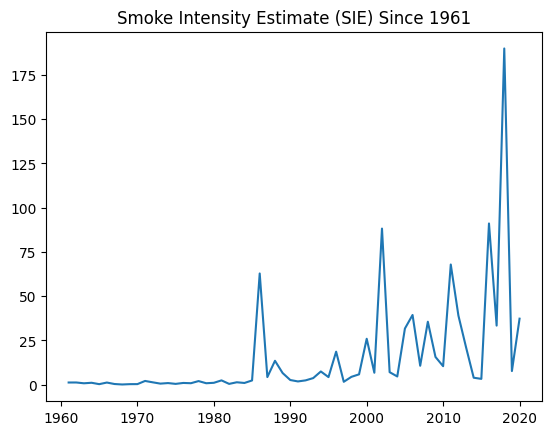

In [473]:
plt.plot(fie_by_year.index, fie_by_year["smoke_intensity_est"])
plt.title("Smoke Intensity Estimate (SIE) Since 1961")
plt.show()

## AQI Data


In [474]:
gaseous_aqi_prefix = "../intermediate_data/gaseous_aqi_"
particulate_aqi_prefix = "../intermediate_data/particulate_aqi_"

START_YEAR = 1975
END_YEAR = 2023

aqi_data = []

years = range(START_YEAR, END_YEAR)

for year in years:

    gaseous_filename = gaseous_aqi_prefix + str(year) + ".json"
    print(gaseous_filename)

    with open(gaseous_filename, "r") as gaseous_file:
        gaseous_data = json.load(gaseous_file)

    for d in gaseous_data["Data"]:
        d["year"] = year
        aqi_data.append(d)

    particulate_filename = particulate_aqi_prefix + str(year) + ".json"
    print(particulate_filename)

    with open(particulate_filename, "r") as particulate_file:
        particulate_data = json.load(particulate_file)

    for d in particulate_data["Data"]:
        d["year"] = year
        aqi_data.append(d)

../intermediate_data/gaseous_aqi_1975.json
../intermediate_data/particulate_aqi_1975.json
../intermediate_data/gaseous_aqi_1976.json
../intermediate_data/particulate_aqi_1976.json
../intermediate_data/gaseous_aqi_1977.json
../intermediate_data/particulate_aqi_1977.json
../intermediate_data/gaseous_aqi_1978.json
../intermediate_data/particulate_aqi_1978.json
../intermediate_data/gaseous_aqi_1979.json
../intermediate_data/particulate_aqi_1979.json
../intermediate_data/gaseous_aqi_1980.json
../intermediate_data/particulate_aqi_1980.json
../intermediate_data/gaseous_aqi_1981.json
../intermediate_data/particulate_aqi_1981.json
../intermediate_data/gaseous_aqi_1982.json
../intermediate_data/particulate_aqi_1982.json
../intermediate_data/gaseous_aqi_1983.json
../intermediate_data/particulate_aqi_1983.json
../intermediate_data/gaseous_aqi_1984.json
../intermediate_data/particulate_aqi_1984.json
../intermediate_data/gaseous_aqi_1985.json
../intermediate_data/particulate_aqi_1985.json
../interme

In [475]:
len(aqi_data)

600866

In [476]:
import pandas as pd
aqi_df = pd.DataFrame(aqi_data)

In [477]:
set(aqi_df["parameter"])

{'Acceptable PM2.5 AQI & Speciation Mass',
 'Carbon monoxide',
 'Nitrogen dioxide (NO2)',
 'Ozone',
 'PM10 Total 0-10um STP',
 'PM2.5 - Local Conditions',
 'Sulfur dioxide'}

In [478]:
aqi_df_ = aqi_df.drop(columns=[
    "parameter_code",
    "poc",
    "latitude",
    "longitude",
    "datum",
    "sample_duration_code",
    "sample_duration",
    "pollutant_standard",
    "event_type",
    "method_code",
    "method",
    "date_of_last_change",
    "site_address",
    "local_site_name"
])

In [526]:
aqi_df_.dtypes

state_code              object
county_code             object
site_number             object
parameter               object
date_local              object
units_of_measure        object
observation_count        int64
observation_percent    float64
validity_indicator      object
arithmetic_mean        float64
first_max_value        float64
first_max_hour           int64
aqi                    float64
state                   object
county                  object
city                    object
cbsa_code               object
cbsa                    object
year                     int64
dtype: object

In [527]:
index_columns = ["state", "county", "city",
                 "year", "date_local", "validity_indicator"]

In [528]:
aqi_df_dedup = aqi_df_.drop_duplicates(subset=(index_columns+["parameter"]))

In [529]:
aqi_pivoted = (aqi_df_dedup.pivot(index=index_columns,
                                  columns="parameter",
                                  values="aqi")
               .reset_index()
               .rename(columns={
                   "Acceptable PM2.5 AQI & Speciation Mass": "acceptable_pm2.5",
                   "Carbon monoxide": "co",
                   "Nitrogen dioxide (NO2)": "no2",
                   "Ozone": "o3",
                   "PM10 Total 0-10um STP": "pm10",
                   "PM2.5 - Local Conditions": "pm2.5_local",
                   "Sulfur dioxide": "so2"
               }))

In [530]:
AQI_POLLUTANTS = ["acceptable_pm2.5", "co",
                  "no2", "o3", "pm10", "pm2.5_local", "so2"]

In [531]:
FIRE_SEASON_MONTHS = {5, 6, 7, 8, 9, 10}

fire_season_aqi = aqi_pivoted.loc[
    pd.to_datetime(
        aqi_pivoted["date_local"]).dt.month.isin(FIRE_SEASON_MONTHS)]

fire_season_aqi

parameter,state,county,city,year,date_local,validity_indicator,acceptable_pm2.5,co,no2,o3,pm10,pm2.5_local,so2
39,Colorado,Alamosa,Not in a city,1988,1988-05-01,Y,NaN,NaN,NaN,NaN,NaN,NaN,NaN
40,Colorado,Alamosa,Not in a city,1988,1988-05-02,Y,NaN,NaN,NaN,NaN,NaN,NaN,NaN
41,Colorado,Alamosa,Not in a city,1988,1988-05-03,Y,NaN,NaN,NaN,NaN,NaN,NaN,NaN
42,Colorado,Alamosa,Not in a city,1988,1988-05-04,Y,23.0,NaN,NaN,NaN,NaN,NaN,NaN
43,Colorado,Alamosa,Not in a city,1988,1988-05-05,Y,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
63664,Colorado,Teller,Not in a city,1990,1990-08-11,Y,NaN,NaN,NaN,NaN,NaN,NaN,3.0
63665,Colorado,Teller,Not in a city,1990,1990-08-12,Y,NaN,NaN,NaN,NaN,NaN,NaN,3.0
63666,Colorado,Teller,Not in a city,1990,1990-08-13,Y,NaN,NaN,NaN,NaN,NaN,NaN,0.0
63667,Colorado,Teller,Not in a city,1990,1990-08-14,Y,NaN,NaN,NaN,NaN,NaN,NaN,0.0


In [532]:
fire_season_aqi_daily = (fire_season_aqi[["date_local"] + AQI_POLLUTANTS]
                         .groupby("date_local")
                         .mean()
                         .reset_index())

In [533]:
fire_season_aqi_daily["aqi_daily_est"] = fire_season_aqi_daily[AQI_POLLUTANTS].max(axis=1)

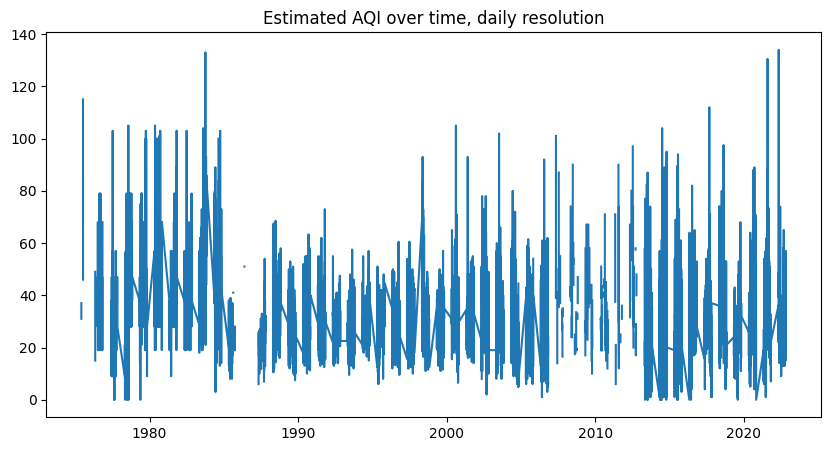

In [534]:
df = fire_season_aqi_daily.copy()

plt.figure(figsize=(10, 5))
plt.plot(pd.to_datetime(df["date_local"]), df["aqi_daily_est"])
plt.title("Estimated AQI over time, daily resolution")
plt.show()

In [535]:
fire_season_aqi_daily["month"] = pd.to_datetime(
    fire_season_aqi_daily["date_local"]).dt.to_period("M")

In [536]:
fire_season_aqi_monthly = (fire_season_aqi_daily[["month"] + AQI_POLLUTANTS]
                           .groupby("month")
                           .mean()
                           .reset_index())

In [537]:
fire_season_aqi_monthly["aqi_monthly_est"] = fire_season_aqi_monthly[AQI_POLLUTANTS].max(
    axis=1)

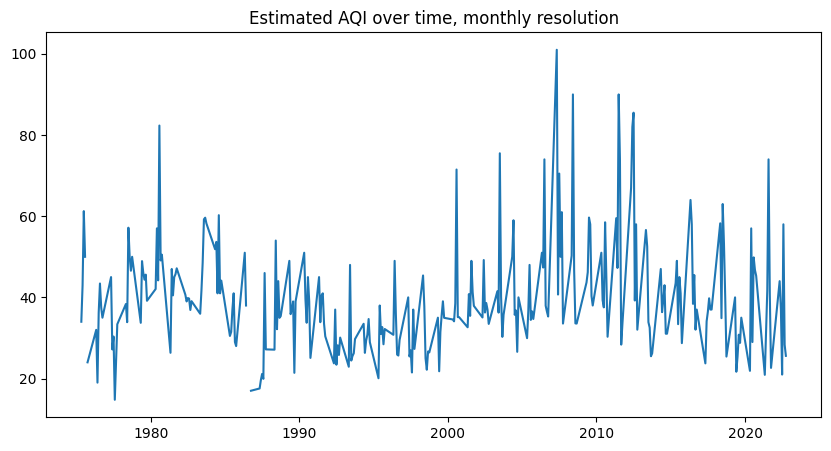

In [538]:
df = fire_season_aqi_monthly.copy()

plt.figure(figsize=(10, 5))
plt.plot(df["month"].dt.to_timestamp(), df["aqi_monthly_est"])
plt.title("Estimated AQI over time, monthly resolution")
plt.show()

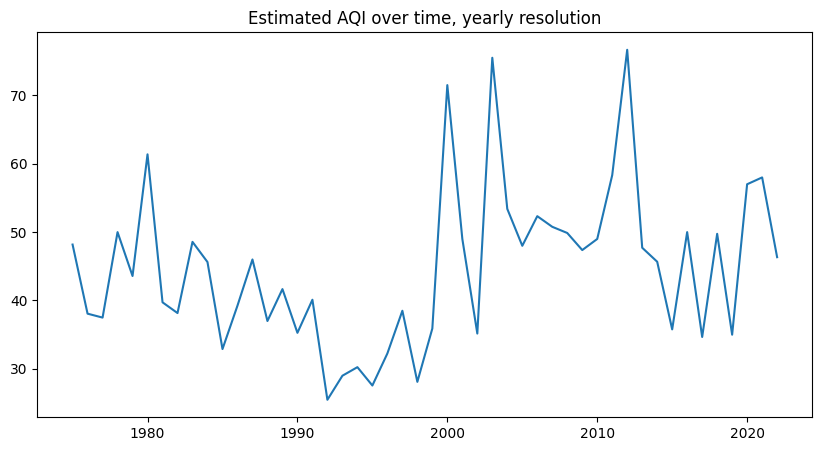

In [539]:
fire_season_aqi_daily["year"] = pd.to_datetime(
    fire_season_aqi_daily["date_local"]).dt.to_period("Y")

fire_season_aqi_yearly = (fire_season_aqi_daily[["year"] + AQI_POLLUTANTS]
                           .groupby("year")
                           .mean()
                           .reset_index())

fire_season_aqi_yearly["aqi_yearly_est"] = fire_season_aqi_yearly[AQI_POLLUTANTS].max(
    axis=1)

df = fire_season_aqi_yearly.copy()

plt.figure(figsize=(10, 5))
plt.plot(df["year"].dt.to_timestamp(), df["aqi_yearly_est"])
plt.title("Estimated AQI over time, yearly resolution")
plt.show()

In [540]:
fire_season_aqi_yearly = fire_season_aqi_yearly[["year", "aqi_yearly_est"]].set_index("year")

<div style="page-break-after: always;"></div>

## Visualizations

Number of fires occurring every 50-mile distance from Pueblo, CO (up to 1800 miles away)

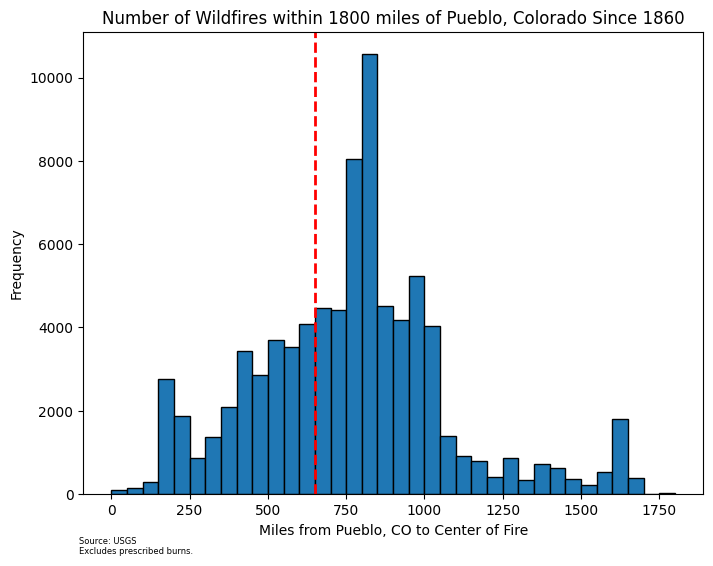

In [541]:
# Define the start and stop values
bins = np.linspace(0,1800,37)
plt.figure(figsize=(8,6))
plt.hist(wildfires_within_1800_mi["centroid_distance_to_pueblo"], bins=bins, edgecolor="black")
plt.title(f"Number of Wildfires within 1800 miles of Pueblo, Colorado Since {min(wildfires_within_1800_mi["Fire_Year"])}")
plt.xlabel("Miles from Pueblo, CO to Center of Fire")
plt.ylabel("Frequency")
plt.figtext(0.12, 0.01, 'Source: USGS\nExcludes prescribed burns.', ha='left', fontsize=6)
plt.axvline(x=650, color='red', linestyle='--', linewidth=2)
plt.show()

### Total Acres Burned by Year

Text(0.12, 0.01, 'Source: USGS\nExcludes prescribed burns.')

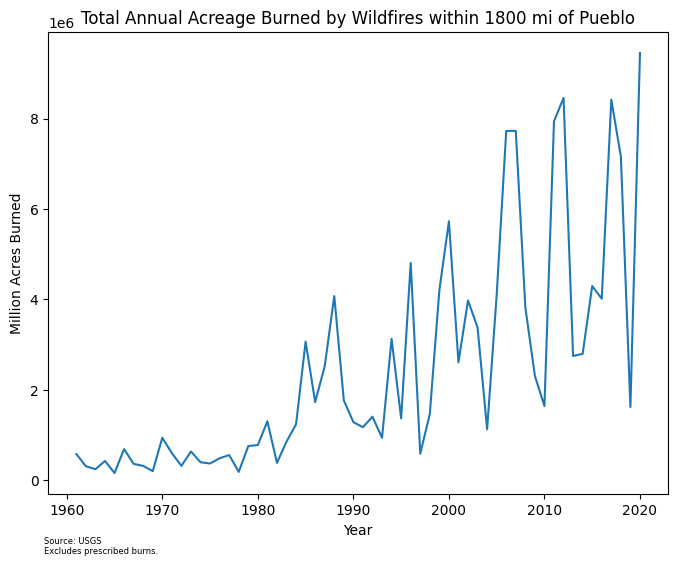

In [543]:
wildfires_within_1800_mi_since_1961 = (
    wildfires_within_1800_mi
    .loc[wildfires_within_1800_mi["Fire_Year"] >=1961, ["Fire_Year", "GIS_Acres"]]
    .groupby("Fire_Year")
    .sum()
)
plt.figure(figsize=(8,6))
plt.plot(wildfires_within_1800_mi_since_1961.index, wildfires_within_1800_mi_since_1961["GIS_Acres"]) 
plt.title("Total Annual Acreage Burned by Wildfires within 1800 mi of Pueblo")
plt.xlabel("Year")
plt.ylabel("Million Acres Burned")
plt.figtext(0.12, 0.01, 'Source: USGS\nExcludes prescribed burns.', ha='left', fontsize=6)

### Time Series of Fire Estimate and AQI

In [637]:
fie = np.array(fie_by_year.reset_index()["smoke_intensity_est"])
aqi = np.array(fire_season_aqi_yearly["aqi_yearly_est"])

In [639]:
years = range(1961, 2021)

x = pd.DataFrame({
    "year": years,
    "fie": fie
})

years = range(1975, 2023)

y = pd.DataFrame({
    "year": years,
    "aqi": aqi
})

In [644]:
df_for_viz = x.merge(y, on="year").set_index("year")

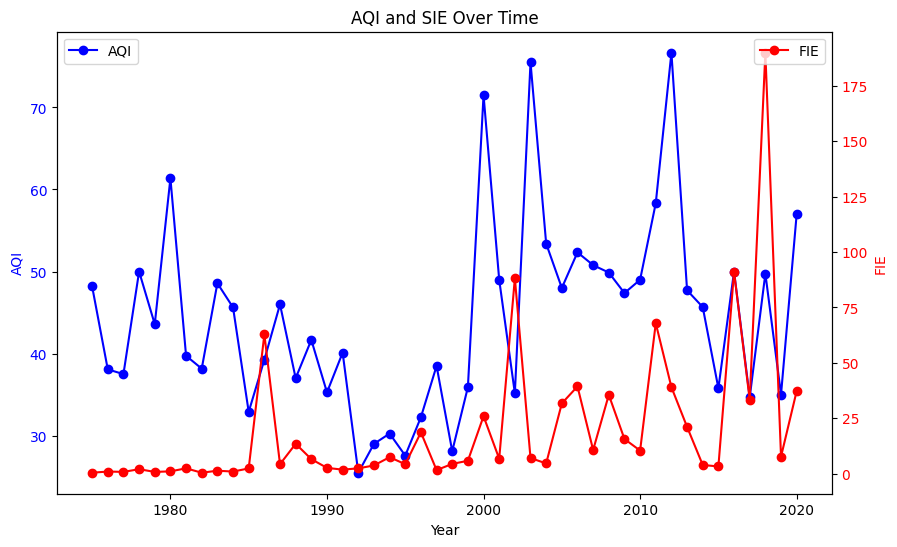

In [649]:

fig, ax1 = plt.subplots(figsize=(10, 6))

ax1.plot(df_for_viz.index, df_for_viz['aqi'], color='b', label='AQI', marker='o')
ax1.set_xlabel('Year')
ax1.set_ylabel('AQI', color='b')
ax1.tick_params(axis='y', labelcolor='b')
ax1.set_title('AQI and SIE Over Time')

ax2 = ax1.twinx()
ax2.plot(df_for_viz.index, df_for_viz['fie'], color='r', label='FIE', marker='o')
ax2.set_ylabel('FIE', color='r')
ax2.tick_params(axis='y', labelcolor='r')

ax1.legend(loc='upper left')
ax2.legend(loc='upper right')

plt.show()

## Appendix

### Data Processing Note
Appendix note: the problem with AQI data is NOT that I am directly accessing AQIs rather than calculating it from the underlying raw concentrations; just as many of these are null as the AQI values.

In [499]:
aqi_pivoted.isna().mean()

parameter
state                 0.000000
county                0.000000
city                  0.000000
year                  0.000000
date_local            0.000000
validity_indicator    0.000000
acceptable_pm2.5      0.935369
co                    0.999309
no2                   0.786411
o3                    0.990278
pm10                  0.707943
pm2.5_local           0.888659
so2                   0.755784
dtype: float64